In [1]:
from math_primitives.DynamicSplineGenerator import *
from math_primitives.QuarticSplineGenerator import *
from scipy.interpolate import CubicSpline
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
from typing import Tuple
import sympy
from sympy import Matrix, Symbol, solve
from random import random
import timeit
from time import process_time

In [2]:
def make_data(n: int, decay: float = 0.4) -> Tuple[NDArray[np.float64], NDArray[np.float64]]:
    data = np.zeros((n,))
    x = np.zeros((n,))

    d = 0
    data[0] = 0
    x[0] = 0
    for i in range(1, n):
        d += (0.5*random() - 0.25) - decay*d
        dx = 0.5*random() + 0.75
        x[i] = x[i-1] + dx
        data[i] = data[i-1] + d*dx
        
    return x, data

In [3]:
x, data = make_data(40,0.7)

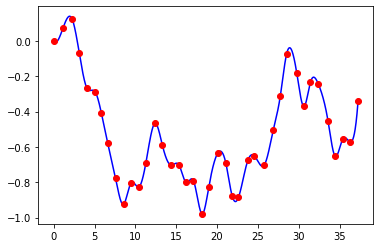

In [4]:
scipy_spline = CubicSpline(x, data)

x_dense = np.linspace(x[0], x[-1], 2000)
plt.plot(x_dense, scipy_spline(x_dense), 'b-', x, data, 'ro')

In [5]:
timedvals = [TimedVal(val=v, time=t) for (t, v) in zip(x, data)]

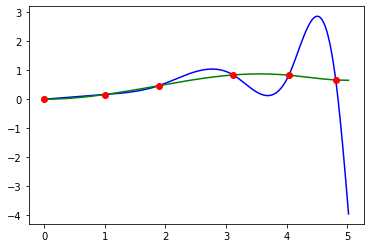

In [5]:
spline_gen = DynamicSplineGenerator(timedvals, (data[1]-data[0])/(x[1]-x[0]), 0)
spline1 = spline_gen(timedvals)

x_dense = np.linspace(x[0], x[-1], 4000)
vals = [spline1(x) for x in x_dense]
max_p = 6
plt.plot(x_dense[:max_p*100-60], vals[:max_p*100-60], 'b-',
         x_dense[:max_p*100-60], scipy_spline(x_dense[:max_p*100-60]), 'g-', 
         x[:max_p], data[:max_p], 'ro')

In [6]:
quart_spline_gen = QuarticSplineGenerator(timedvals, (data[1]-data[0])/(x[1]-x[0]), 0)
quart_spline1 = quart_spline_gen(timedvals)

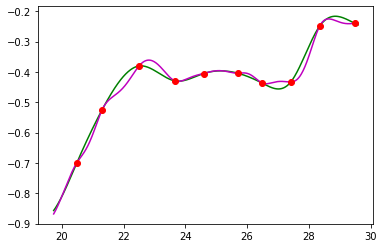

In [11]:
x_dense = np.linspace(x[0], x[-1], 2000)
#vals = [spline1(x) for x in x_dense]
vals_sympy = [quart_spline1(x) for x in x_dense]
min_p = 20
max_p = 30
plt.plot(#x_dense[:max_p*100-50], vals[:max_p*100-50], 'b-',
         x_dense[min_p*50:max_p*50], scipy_spline(x_dense[min_p*50:max_p*50]), 'g-',
         x_dense[min_p*50:max_p*50], vals_sympy[min_p*50:max_p*50], 'm-',
         x[min_p:max_p], data[min_p:max_p], 'ro')

In [10]:
# For derivative matching at the end
tol = 1e-5
for i in range(1, len(timedvals)):
    goal = (timedvals[i].val - timedvals[i-1].val)/(timedvals[i].time - timedvals[i-1].time)
    actual = quart_spline_gen.coeff[i-1].dt(timedvals[i].time)
    print(f"goal: {goal} -> actual: {actual} => {'OK' if abs(goal - actual) < tol else 'WRONG'}")

goal: -0.0923635763362743 -> actual: -0.0923635763362743 => OK
goal: 0.028546532536770947 -> actual: 0.028546532536771127 => OK
goal: -0.0016820551127189767 -> actual: -0.0016820551127190858 => OK
goal: 0.03320893383782522 -> actual: 0.033208933837825014 => OK
goal: 0.23691901813758884 -> actual: 0.23691901813759014 => OK
goal: 0.25837699638424627 -> actual: 0.25837699638424744 => OK
goal: -0.028787503072018123 -> actual: -0.028787503072019105 => OK
goal: -0.23875978311313098 -> actual: -0.238759783113131 => OK
goal: -0.17224756056941068 -> actual: -0.17224756056941076 => OK
goal: -0.12868565938005125 -> actual: -0.128685659380051 => OK
goal: -0.22867668198817165 -> actual: -0.2286766819881712 => OK
goal: -0.22974122142507652 -> actual: -0.22974122142507564 => OK
goal: -0.06011858977364826 -> actual: -0.06011858977364831 => OK
goal: 0.08539967864392065 -> actual: 0.08539967864392056 => OK
goal: 0.027386486609142353 -> actual: 0.02738648660914228 => OK
goal: -0.12764797687331292 -> actu

In [ ]:
# For derivative matching in the middle
tol = 1e-5
for i in range(1, len(timedvals)):
    goal = (timedvals[i].val - timedvals[i-1].val)/(timedvals[i].time - timedvals[i-1].time)
    actual = quart_spline_gen.coeff[i-1].dt((timedvals[i].time+timedvals[i-1].time)/2)
    print(f"goal: {goal} -> actual: {actual} => {'OK' if abs(goal - actual) < tol else 'WRONG'}")

In [ ]:
# Timing

In [14]:
times = {}
for i in range(1, 3000):
    x, y = make_data(i)
    data = [TimedVal(time=t, val=v) for (t, v) in zip(x, y)]
    
    start = process_time()
    gen = QuarticSplineGenerator(data, (y[1]-y[0])/(x[1]-x[0]) if i > 1 else 0, 0)
    mid = process_time()
    f = gen(data)
    end = process_time()
    
    times[i] = (end-start, end-mid)

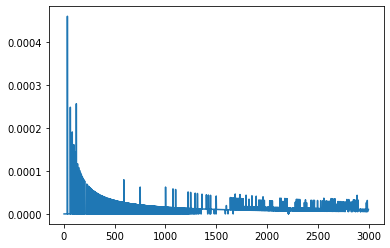

In [19]:
t = [times[i][0]/i for i in range(1,3000)]
n = list(range(1,3000))
plt.plot(n, t)

In [22]:
num = 10000
res = []

x, y = make_data(num+5, 0.3)
timedvals = [TimedVal(time=t, val=v) for (t, v) in zip(x[:5], y[:5])]
gen = QuarticSplineGenerator(timedvals, (y[1]-y[0])/(x[1]-x[0]), 0)
f = gen(timedvals)

for i in range(5,num+5):
    timedvals.append(TimedVal(time=x[i], val=y[i]))
    
    start = process_time()
    f = gen(timedvals)
    end = process_time()
    
    res.append(end-start)
    
print(sum(res)/len(res))

1.5625e-05


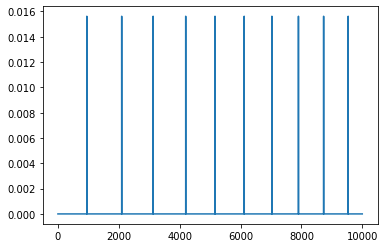

In [23]:
n = list(range(len(res)))
plt.plot(n, res)

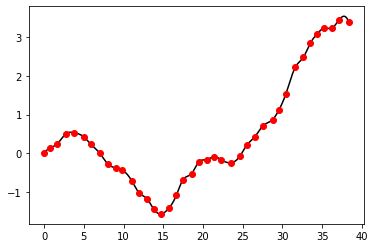

In [29]:
# Compare mode
x, data = make_data(40, 0.2)

scipy_spline = CubicSpline(x, data)

x_dense = np.linspace(x[0], x[-1], 2000)
plt.plot(x_dense, scipy_spline(x_dense), 'k-', 
         x, data, 'ro')

timedvals = [TimedVal(val=v, time=t) for (t, v) in zip(x, data)]

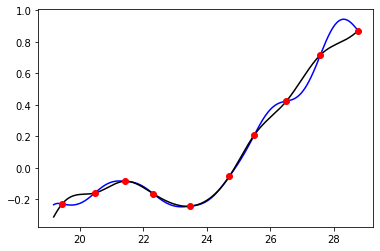

In [31]:
least_bendy = QuarticSplineGenerator(timedvals, (data[1]-data[0])/(x[1]-x[0]), 0, mode="least bendy")
spline1 = least_bendy(timedvals)
match_end = QuarticSplineGenerator(timedvals, (data[1]-data[0])/(x[1]-x[0]), 0, mode="match end")
spline2 = match_end(timedvals)
match_middle = QuarticSplineGenerator(timedvals, (data[1]-data[0])/(x[1]-x[0]), 0, mode="match middle")
spline3 = match_middle(timedvals)

x_dense = np.linspace(x[0], x[-1], 2000)
vals1 = [spline1(x) for x in x_dense]
vals2 = [spline2(x) for x in x_dense]
vals3 = [spline3(x) for x in x_dense]

min_p = 20
max_p = 30

plt.plot(x_dense[min_p*50:max_p*50], vals1[min_p*50:max_p*50], 'b-',
         #x_dense[min_p*50:max_p*50], vals2[min_p*50:max_p*50], 'g-',
         #x_dense[min_p*50:max_p*50], vals3[min_p*50:max_p*50], 'm-',
         x_dense[min_p*50:max_p*50], scipy_spline(x_dense[min_p*50:max_p*50]), 'k-',
         x[min_p:max_p], data[min_p:max_p], 'ro')